# Netflix Sentiment Analysis

# Imports

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertConfig
import torch
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Sequential


os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Functions

In [2]:
def check_for_nulls_dupes(df):
  print(f"The amount of NaN values: {df.isna().sum()}")
  print(f"The amount of Duplicated values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  
  filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', "", word_tokens).split(" ")
  filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()


In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/netflix_reviews.csv",nrows=10000)
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,1772b40f-8cfd-4c56-a370-c944e5b5ce48,Gato Reviews,Utter trash. Been a customer for over 10 years...,1,0,8.114.0 build 19 50680,2024-05-23 22:35:45,8.114.0 build 19 50680
1,b6b64d5c-30f6-4bed-8d66-9b4582e72e3b,Quincy Alleyne,Good,5,0,8.115.2 build 6 50688,2024-05-23 22:34:47,8.115.2 build 6 50688
2,8be7d06b-f90e-4ca7-abf6-f908b40946e2,nez zuber,The only streaming service that beats Netflix ...,2,0,NaN,2024-05-23 22:33:52,NaN
3,72485684-9e73-4dca-a580-0a92b3a3a7e6,Elon Frett,Everything that's objectively good gets remove...,1,0,8.109.0 build 7 50647,2024-05-23 22:30:43,8.109.0 build 7 50647
4,348796c3-0056-4491-80f7-d6c38fcb2790,kwakhanya bambeni,Wish the owner be a trillioner because he/she ...,4,0,NaN,2024-05-23 22:30:27,NaN
...,...,...,...,...,...,...,...,...
9995,260fc52a-ec27-468e-8029-7029391e2dcc,hafiz ejaz,I have used the previous version of the Netfli...,3,836,8.52.2 build 14 50335,2022-12-17 04:34:27,8.52.2 build 14 50335
9996,2ef0eca9-14bf-42f4-b2bb-3836e3ce29eb,Nikolas Mitchell,"I'm disappointed by this recent ""update"" it ma...",1,2,NaN,2023-05-10 11:29:41,NaN
9997,ed5e9c73-0448-4603-a551-8eef04b9730f,William Pearson,A great way to watch some shows and movies! An...,4,274,7.84.1 build 28 35243,2020-12-28 20:03:15,7.84.1 build 28 35243
9998,47441c89-bab5-42b3-b249-a7ce0b43598a,Sorsa,I have limited space on the internal storage o...,2,16,8.30.3 build 14 50239,2023-08-23 15:51:10,8.30.3 build 14 50239


# Check for Nulls and Dupe Values

In [4]:
check_for_nulls_dupes(df)

The amount of NaN values: reviewId                  0
userName                  0
content                   2
score                     0
thumbsUpCount             0
reviewCreatedVersion    971
at                        0
appVersion              971
dtype: int64
The amount of Duplicated values: 287


In [5]:
df.dropna(inplace=True)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(8802, 8)

# Check For Class Imabalance

# Scores Breakdown

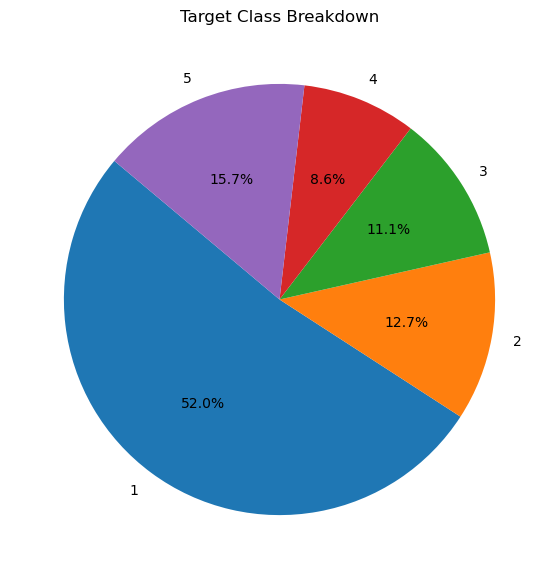

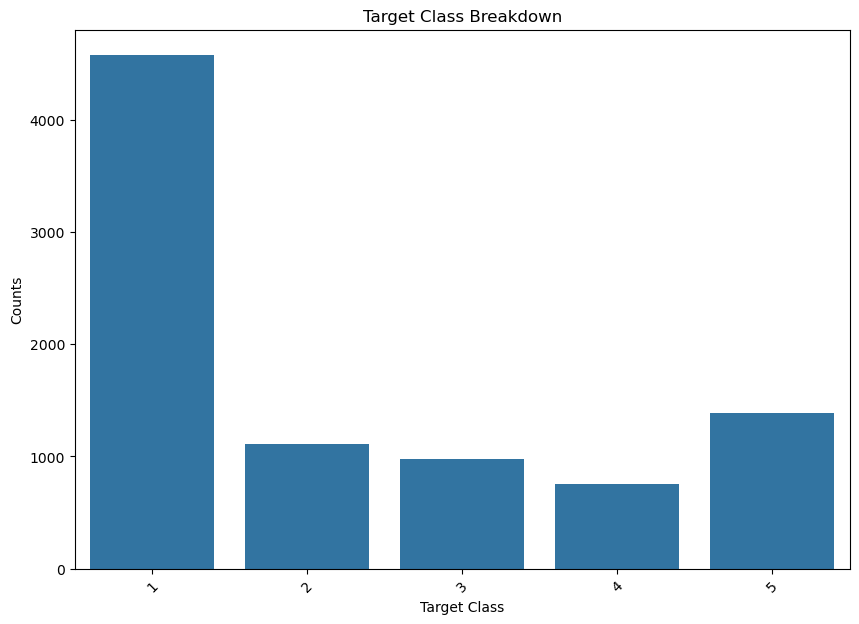

In [8]:
check_class_imbalance(df["score"])

# We have a skewed class imbalance, we may need to address this with over sampling methods to ensure our model is able to generalize to new data

In [9]:
df.dtypes

reviewId                object
userName                object
content                 object
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    object
at                      object
appVersion              object
dtype: object

# Drop the columns we do not need

In [10]:
df.drop(["reviewId", "userName", "reviewCreatedVersion", "appVersion"],axis=1, inplace=True)

In [11]:
df

,content,score,thumbsUpCount,at
0,Utter trash. Been a customer for over 10 years...,1,0,2024-05-23 22:35:45
1,Good,5,0,2024-05-23 22:34:47
3,Everything that's objectively good gets remove...,1,0,2024-05-23 22:30:43
5,Amazing app for watching,5,0,2024-05-23 22:16:49
8,I am unable to open the app 500.-172 501.-172 ...,1,0,2024-05-23 21:52:53
...,...,...,...,...
9994,Netflix has gone downhill. Raised the price of...,2,97,2022-07-01 14:12:56
9995,I have used the previous version of the Netfli...,3,836,2022-12-17 04:34:27
9997,A great way to watch some shows and movies! An...,4,274,2020-12-28 20:03:15
9998,I have limited space on the internal storage o...,2,16,2023-08-23 15:51:10


In [12]:
df.describe()

,score,thumbsUpCount
count,8802.000000,8802.000000
mean,2.234492,73.594978
std,1.527910,294.274003
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,3.000000,7.000000
max,5.000000,6990.000000


# Check for Skew in distribution

In [13]:
df["thumbsUpCount"].skew()

8.389731003518218

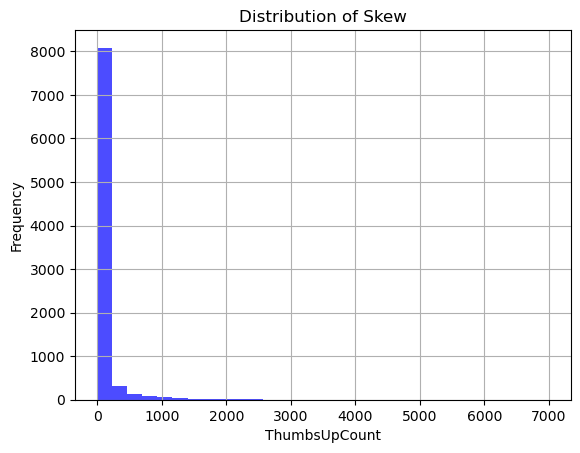

In [14]:
df["thumbsUpCount"].hist(bins=30, color="blue", alpha=0.7)
plt.title("Distribution of Skew")
plt.xlabel("ThumbsUpCount")
plt.ylabel("Frequency")
plt.show()

In [15]:
df["score"].skew()

0.804862869499793

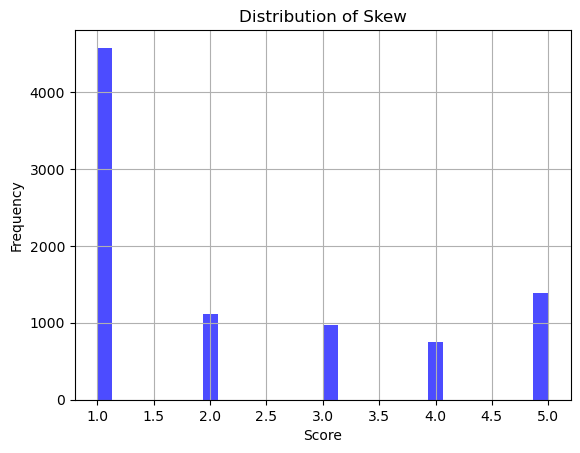

In [16]:
df["score"].hist(bins=30, color="blue", alpha=0.7)
plt.title("Distribution of Skew")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Review count analysis

In [17]:
df["len_of_review_text"] = df["content"].apply(lambda x: len(x))
df["len_of_review_wordcount"] = df["content"].apply(lambda x: len(x.split()))

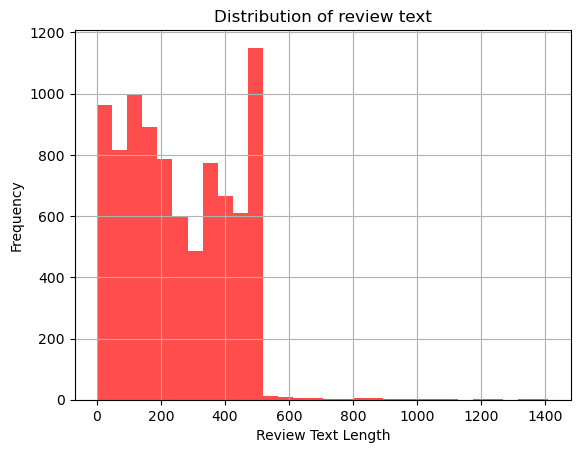

In [18]:
df["len_of_review_text"].hist(bins=30, color="red", alpha=0.7)
plt.title("Distribution of review text")
plt.xlabel("Review Text Length")
plt.ylabel("Frequency")
plt.show()

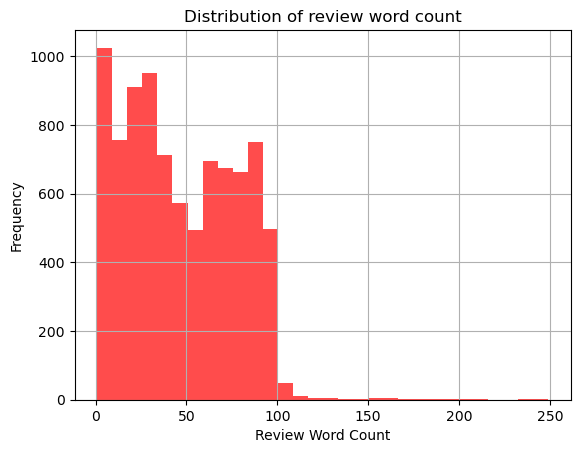

In [19]:
df["len_of_review_wordcount"].hist(bins=30, color="red", alpha=0.7)
plt.title("Distribution of review word count")
plt.xlabel("Review Word Count")
plt.ylabel("Frequency")
plt.show()

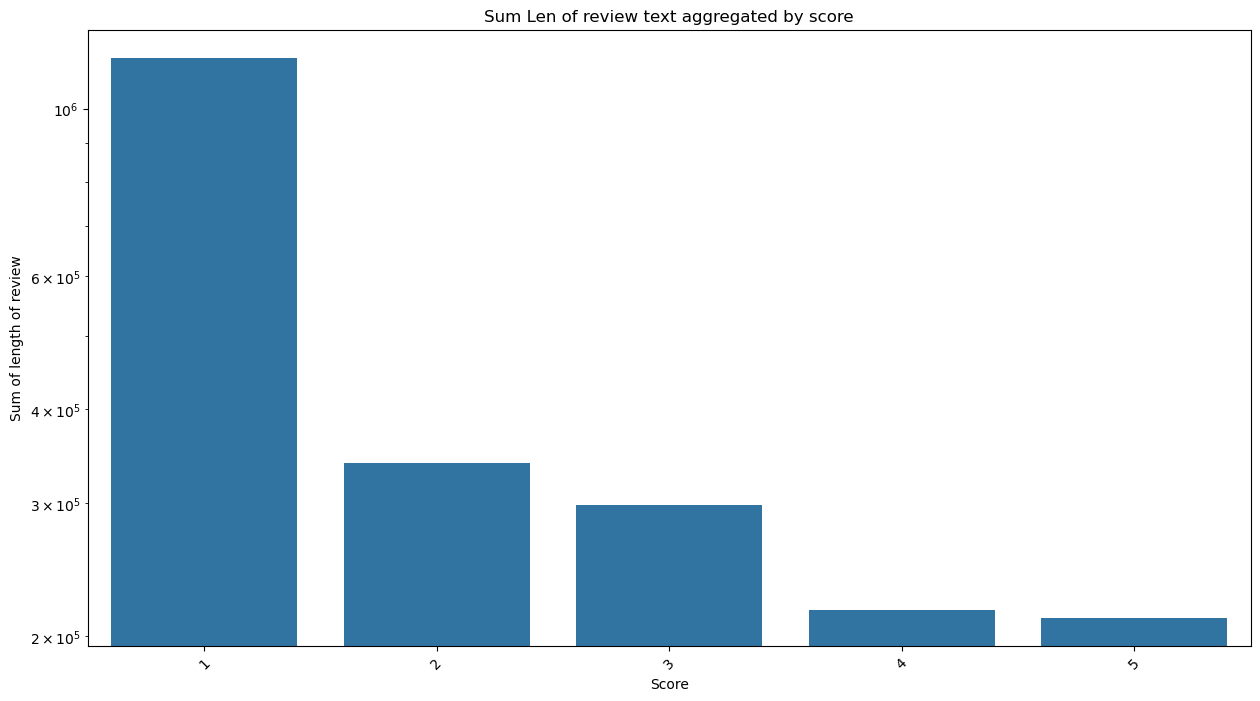

In [20]:
grouped_df = df.groupby("score")["len_of_review_text"].sum().reset_index()

plt.figure(figsize=(15,8))
sns.barplot(data=grouped_df, x="score", y="len_of_review_text")
plt.title("Sum Len of review text aggregated by score")
plt.xlabel("Score")
plt.ylabel("Sum of length of review")
plt.yscale("log")
plt.xticks(rotation=45)
plt.show()

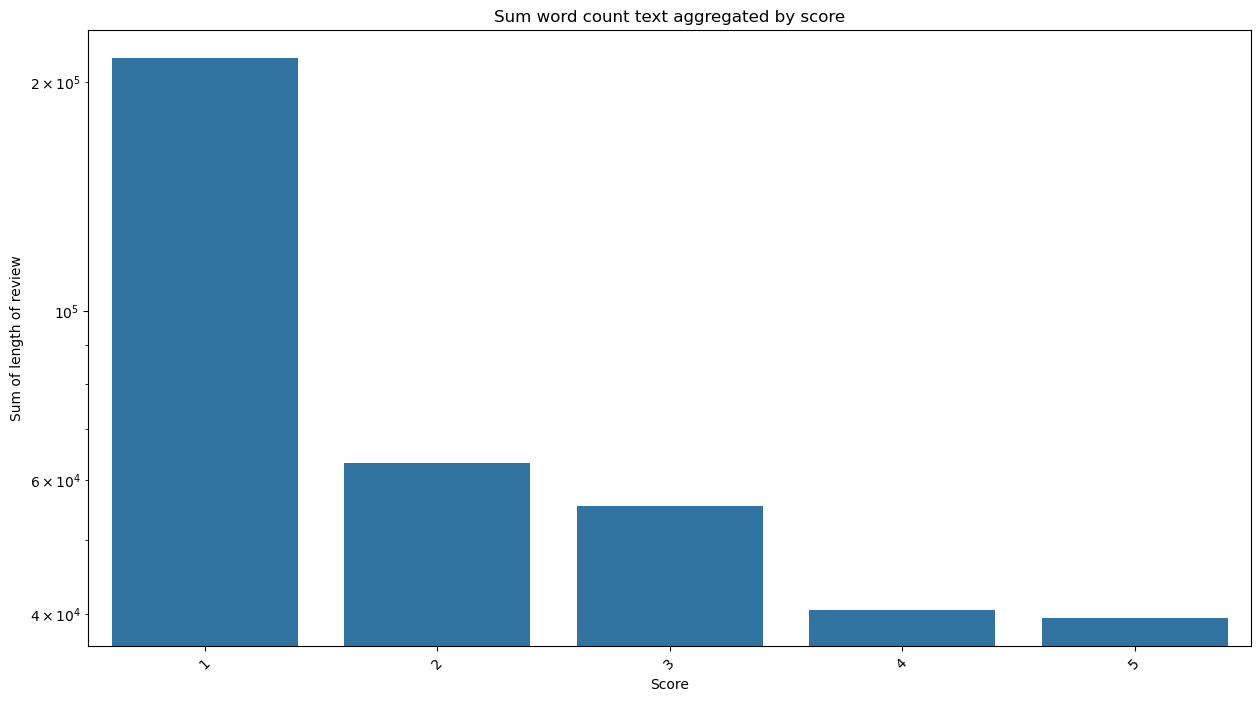

In [21]:
grouped_df = df.groupby("score")["len_of_review_wordcount"].sum().reset_index()

plt.figure(figsize=(15,8))
sns.barplot(data=grouped_df, x="score", y="len_of_review_wordcount")
plt.title("Sum word count text aggregated by score")
plt.xlabel("Score")
plt.ylabel("Sum of length of review")
plt.yscale("log")
plt.xticks(rotation=45)
plt.show()

# Data Preprocessing

In [22]:
df["content"] = df["content"].apply(lambda x: remove_stop_words(x))
df["score"] = df["score"].apply(lambda x: "postive" if x>=4 else "neg" if x<3 else "neu")
df["at"] = pd.to_datetime(df["at"])

df["day"] = df["at"].dt.day
df["month"] = df["at"].dt.month
df["year"] = df["at"].dt.year
df["hour"] = df["at"].dt.hour

df.drop("at", axis=1, inplace=True)

<AxesSubplot:>

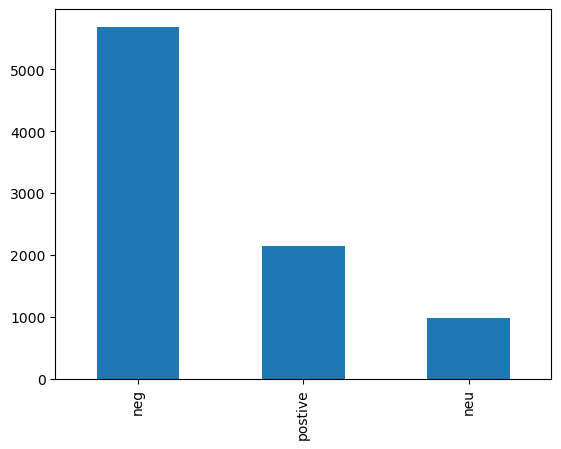

In [51]:
df["score"].value_counts().plot.bar()

# Separate Feature Variables

In [28]:
X, y = df.drop("score", axis=1), df["score"]

NUM_LABELS = len(np.unique(y))

# Bert Model

In [46]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

config = DistilBertConfig.from_pretrained(model_name, num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
tokens = tokenizer(df["content"].tolist(), padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
  outputs = model(**tokens)
  predictions = torch.nn.functional.softmax(outputs.logits,dim=1)
  
predicted_labels = predictions.argmax(dim=1)

df["predicted_label"] = predicted_labels.numpy()

<AxesSubplot:>

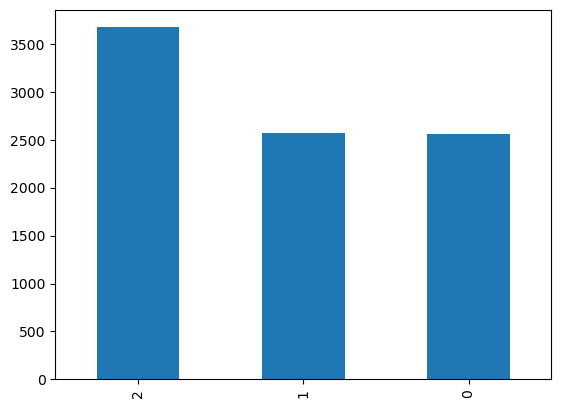

In [53]:
df["predicted_label"].value_counts().plot.bar()

In [54]:
df["predicted_label"].value_counts()

2    3673
1    2570
0    2559
Name: predicted_label, dtype: int64

In [55]:
df["score"].value_counts()

neg        5688
postive    2139
neu         975
Name: score, dtype: int64

# LSTM Model

In [57]:
model = Sequential()

vocab_size = len(tokenizer.get_vocab())+1
model.add(Embedding(input_dim=vocab_size, output_dim=32))
model.add(Bidirectional(LSTM(32, activation="tanh")))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(NUM_LABELS, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])